In [1]:
""" 
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import pearsonr

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
fp = os.path.join(projdir,'data/tabular/mod/gridstats_lf_gs.csv')
tm = pd.read_csv(fp)
tm.drop(columns=['Unnamed: 0'], inplace=True)
tm.columns

Index(['Fire_ID', 'Fire_Name', 'grid_idx', 'fortypnm_gp', 'proportion', 'CC',
       'CH', 'CBH', 'CBD', 'BALIVE', 'SDI', 'QMD', 'dom_fortyp', 'prop_forest',
       'grid_index', 'grid_area', 'afd_count', 'day_count', 'night_count',
       'unique_days', 'overlap', 'frp_csum', 'frp_max', 'frp_min',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date', 'erc',
       'erc_dv', 'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv',
       'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev', 'slope', 'aspect', 'chili',
       'tpi', 'x', 'y', 'geometry'],
      dtype='object')

In [3]:
len(tm)

138853

In [4]:
# load the CBI data
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_cbibc_forest.csv')
sev = pd.read_csv(fp)
sev.drop(columns=['system:index','.geo'], inplace=True)
# create a unique ID
sev['grid_idx'] = sev['Fire_ID'].astype(str) + sev['grid_index'].astype(str)
print(sev.columns)

# Rename the columns for clarity
cols = ['mean', 'stdDev', 'p90', 'p95', 'p97', 'p99']
for col in cols:
    new_name = 'CBIbc_' + col
    sev.rename(columns={col: new_name}, inplace=True)
sev.drop(columns=['Fire_ID','grid_index'], inplace=True)
sev['grid_idx'] = sev['grid_idx'].astype(int)
# merge the dataframes
tm_sev = tm.merge(sev, on='grid_idx', how='left')
tm_sev[['grid_idx','fortypnm_gp','proportion','frp_max','frp_csum',
        'CBIbc_mean','CBIbc_p90','CBIbc_p95','CBIbc_p97']].head(10)

Index(['Fire_ID', 'grid_index', 'mean', 'p90', 'p95', 'p97', 'p99', 'stdDev',
       'grid_idx'],
      dtype='object')


,grid_idx,fortypnm_gp,proportion,frp_max,frp_csum,CBIbc_mean,CBIbc_p90,CBIbc_p95,CBIbc_p97
0,819725,Aspen,24.117647,14.692515,26.010226,1.140510,1.68,1.92,1.92
1,819725,Douglas-fir,1.176471,14.692515,26.010226,1.140510,1.68,1.92,1.92
2,819725,Spruce-fir,2.352941,14.692515,26.010226,1.140510,1.68,1.92,1.92
3,819725,Aspen–Mixed,11.764706,14.692515,26.010226,1.140510,1.68,1.92,1.92
4,821970,Aspen,39.644970,9.779182,17.566190,0.390073,1.39,1.53,1.60
5,821970,Douglas-fir,1.775148,9.779182,17.566190,0.390073,1.39,1.53,1.60
6,821970,Spruce-fir,4.142012,9.779182,17.566190,0.390073,1.39,1.53,1.60
7,821970,Spruce-fir,14.201183,9.779182,17.566190,0.390073,1.39,1.53,1.60
8,821970,Aspen–Mixed,24.852071,9.779182,17.566190,0.390073,1.39,1.53,1.60
9,821974,Aspen,11.242604,21.670228,35.828136,0.324670,0.64,0.94,1.04


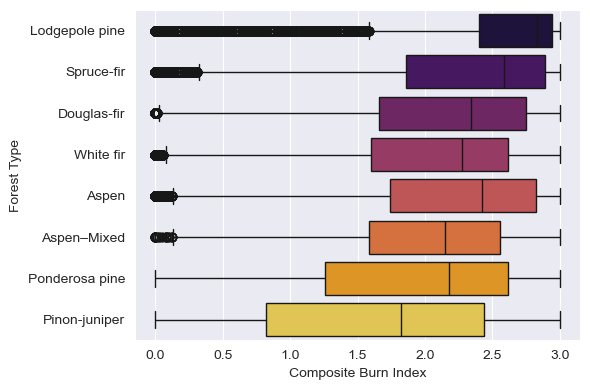


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/Figure_LF_Dom_CBIbc90.png



In [6]:
# Plot FRP by dominant forest type
# # create a dataframe with dominance (>50% of the same species)
# dom = tm_sev[tm_sev['fortyp_pct'] > 0.50]
# Find the median and sort the forest types by FRP
med = tm_sev.groupby('dom_fortyp')['CBIbc_p90'].median().sort_values(ascending=False)
ordered = med.index.tolist()

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=tm_sev, 
    x='CBIbc_p90', 
    y='fortypnm_gp', 
    order=ordered, 
    palette='inferno', 
    dodge=False)

# plt.xscale('log') # log-scale FRP
plt.xlabel('Composite Burn Index')
plt.ylabel('Forest Type')
plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/Figure_LF_Dom_CBIbc90.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [7]:
tm_sev.columns

Index(['Fire_ID', 'Fire_Name', 'grid_idx', 'fortypnm_gp', 'proportion', 'CC',
       'CH', 'CBH', 'CBD', 'BALIVE', 'SDI', 'QMD', 'dom_fortyp', 'prop_forest',
       'grid_index', 'grid_area', 'afd_count', 'day_count', 'night_count',
       'unique_days', 'overlap', 'frp_csum', 'frp_max', 'frp_min',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date', 'erc',
       'erc_dv', 'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv',
       'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev', 'slope', 'aspect', 'chili',
       'tpi', 'x', 'y', 'geometry', 'CBIbc_mean', 'CBIbc_p90', 'CBIbc_p95',
       'CBIbc_p97', 'CBIbc_p99', 'CBIbc_stdDev'],
      dtype='object')

In [8]:
print(len(tm))
print(len(sev))
print(len(tm_sev))

138853
57232
138853


In [10]:
print(f"\nNaNs in CBI: {tm_sev['CBIbc_p90'].isna().sum()}\n")
print(f"NaNs in FRP: {tm_sev['frp_csum'].isna().sum()}\n")
print(f"NaNs in FORTYP: {tm_sev['fortypnm_gp'].isna().sum()}\n")


NaNs in CBI: 0

NaNs in FRP: 0

NaNs in FORTYP: 0



In [11]:
tm_sev = tm_sev[~tm_sev['CBIbc_p90'].isna()]
print(len(tm_sev))

138853


In [12]:
print(tm_sev.columns)

Index(['Fire_ID', 'Fire_Name', 'grid_idx', 'fortypnm_gp', 'proportion', 'CC',
       'CH', 'CBH', 'CBD', 'BALIVE', 'SDI', 'QMD', 'dom_fortyp', 'prop_forest',
       'grid_index', 'grid_area', 'afd_count', 'day_count', 'night_count',
       'unique_days', 'overlap', 'frp_csum', 'frp_max', 'frp_min',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date', 'erc',
       'erc_dv', 'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv',
       'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev', 'slope', 'aspect', 'chili',
       'tpi', 'x', 'y', 'geometry', 'CBIbc_mean', 'CBIbc_p90', 'CBIbc_p95',
       'CBIbc_p97', 'CBIbc_p99', 'CBIbc_stdDev'],
      dtype='object')


In [13]:
tm_sev['fortypnm_gp'].unique()

array(['Aspen', 'Douglas-fir', 'Spruce-fir', 'Aspen–Mixed', 'White fir',
       'Ponderosa pine', 'Pinon-juniper', 'Lodgepole pine'], dtype=object)

In [14]:
# save the table out
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_lf_gs_frp-cbi.csv')
tm_sev.to_csv(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_lf_gs_frp-cbi.csv
